# Load python packages

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics.pairwise import cosine_similarity

# Inital setting for plot size
from matplotlib import rcParams
FIGSIZE=(6, 6)
rcParams['figure.figsize']=FIGSIZE

sc.settings.verbosity = 1
# set number of cores to use
sc.settings.n_jobs = 25
sc.settings.set_figure_params( dpi=300, fontsize=6)

# Load python functions

## Initial settings: color, order, trait

In [2]:
from initial_settings import *

## Similarity of cell types

In [3]:
# Define the colors
colors = ["#2C7BB6", "white", "#D7191C"]  # low, mid, high
n_bins = 100  # Increase this number for smoother transitions
cmap_name = "custom_gradient"

# Create the colormap using 'from_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

def similarity_cell_type_all(adata, cell_type, out_label, fig_size, file_out):
    # all cell_type
    all_cell_types = np.unique(adata.obs[cell_type])
    # cell types in different datasets
    cell_type_aging = np.unique(adata[adata.obs['Batch'] == 'Aging', :].obs[cell_type])
    cell_type_lister = np.unique(adata[adata.obs['Batch'] == 'Lister', :].obs[cell_type])
    fig_width = int(fig_size*len(cell_type_lister)/(len(cell_type_aging)+len(cell_type_lister)))
    fig_height = int(fig_size*len(cell_type_aging)/(len(cell_type_aging)+len(cell_type_lister)))
    

    # obtain average expression profiles for each cell_type in both cohorts    
    mean_expr_aging = {}
    mean_expr_lister = {}
    for sub_cell_type in all_cell_types:
        if(adata[(adata.obs['Batch'] == 'Aging') & (adata.obs[cell_type] == sub_cell_type), :].shape[0] > 0):
            mean_expr_aging[sub_cell_type] = adata[(adata.obs['Batch'] == 'Aging') & (adata.obs[cell_type] == sub_cell_type), :].X.mean(axis = 0).A1
        if(adata[(adata.obs['Batch'] == 'Lister') & (adata.obs[cell_type] == sub_cell_type), :].shape[0] > 0):
            mean_expr_lister[sub_cell_type] = adata[(adata.obs['Batch'] == 'Lister') & (adata.obs[cell_type] == sub_cell_type), :].X.mean(axis = 0).A1
        
    mean_expr_aging = pd.DataFrame(mean_expr_aging).T
    mean_expr_lister = pd.DataFrame(mean_expr_lister).T
            
    # compute pairwise cosine similarities
    with rc_context({'figure.figsize': (fig_width, fig_height)}):
        similar_cos = cosine_similarity(mean_expr_aging, mean_expr_lister)
        ax = sns.heatmap(similar_cos, cmap=cm, annot=True, xticklabels=mean_expr_lister.index, yticklabels=mean_expr_aging.index, linewidths=0)
        # Remove tick lines by setting their length to 0
        ax.tick_params(axis='both', length=0)
        plt.title('Cosine similarity at all age groups (%s)'%out_label)
        # plt.show()
    plt.savefig(file_out, transparent=True, format='pdf')

# Load R libraries

In [ ]:
# monocle3 conda environment
# Load libraries
library(Seurat)
library(Signac)
library(ggplot2)
library(dplyr)
library(zellkonverter)
set.seed(222)
library(RColorBrewer)
library(viridis)
library(monocle3)
library(tidyselect)
library(grid)
library(mgcv)
library(colorspace)
library(ggrepel)
library(igraph)
library(pbapply)
library(devtools)
library(parallel)
library(evobiR)
library(tidyr)
library(cluster)
library(grDevices)
library(repr)
library(zoo)
library(ggnewscale)
library(VennDiagram)
library(ggridges)

In [1]:
# R (Py39_R43_Ju10) for pseudotime UMAT visualization
library(monocle3)
library(ggplot2)
library(cowplot)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading

# Load R functions

## Initial settings: color, order, trait

In [2]:
source("initial_settings.r")

## Load trajectory reconstruction and downstream analysis based on Kriegstein scripts

In [2]:
source("trajectory_reconstruction_based_on_kriestein.r")

## Plot basic density ridgeline

## Regression of pseudotime along age

In [6]:
regress_pt_along_age <- function(cds, lineage){
    par(pty = "s")
    plot(NULL, xlab = "Age", ylab = "Pseudotime", main = paste0("Regression of pseudotime along age in ", lineage), 
         xlim = c(min(colData(cds)$numerical_age), max(colData(cds)$numerical_age)), 
         ylim = c(min(pseudotime(cds)), max(pseudotime(cds))), type="n")
    for(sub_lin in names(cds@lineages)){
        mod.smsp <- smooth.spline(x = cds@colData['numerical_age'][cds@lineages[[sub_lin]], ], 
                                  y = pseudotime(cds)[cds@lineages[[sub_lin]]], 
                                  spar = 1)
        lines(mod.smsp$x, mod.smsp$y, lwd = 3, col = cols_subclass_uni[sub_lin])
    }
    legend("bottomright", legend = names(cds@lineages), col = cols_subclass_uni[names(cds@lineages)], lwd = 3, inset = c(0.02, 0.02))
}

# Load data

In [4]:
adata = sc.read('files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_adata.h5ad')
adata # 1,452,103 × 14,668

AnnData object with n_obs × n_vars = 1452103 × 14668
    obs: 'Batch', 'SubID', 'Age', 'Sex', 'PMI', 'cell_type_uni', 'subclass_uni', 'subtype_uni', 'dev_mat_uni', 'numerical_age', 'stage_id', 'Channel', 'Source', 'poolID', 'prep', 'rep', 'class', 'subclass', 'subtype', 'RL#', 'age', 'chem', 'concat_id', 'Race', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust'
    var: 'gene_id-Aging', 'gene_name-Aging', 'gene_type-Aging', 'gene_chrom-Aging', 'gene_start-Aging', 'gene_end-Aging', 'n_cells-Aging', 'percent_cells-Aging', 'robust-Aging', 'highly_variable_features-Aging', 'ribosomal-Aging', 'mitochondrial-Aging', 'protein_co

# Obtain lineage and merge annotations

In [10]:
ad_oligo = adata[adata.obs['cell_type_uni'].isin(['OPC', 'Oligo']), :]
ad_oligo # 553,620 × 14,668

View of AnnData object with n_obs × n_vars = 553620 × 14668
    obs: 'Batch', 'SubID', 'Age', 'Sex', 'PMI', 'cell_type_uni', 'subclass_uni', 'subtype_uni', 'dev_mat_uni', 'numerical_age', 'stage_id', 'Channel', 'Source', 'poolID', 'prep', 'rep', 'class', 'subclass', 'subtype', 'RL#', 'age', 'chem', 'concat_id', 'Race', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust'
    var: 'gene_id-Aging', 'gene_name-Aging', 'gene_type-Aging', 'gene_chrom-Aging', 'gene_start-Aging', 'gene_end-Aging', 'n_cells-Aging', 'percent_cells-Aging', 'robust-Aging', 'highly_variable_features-Aging', 'ribosomal-Aging', 'mitochondrial-Aging', 'pro

## Cell type similarity between two cohorts

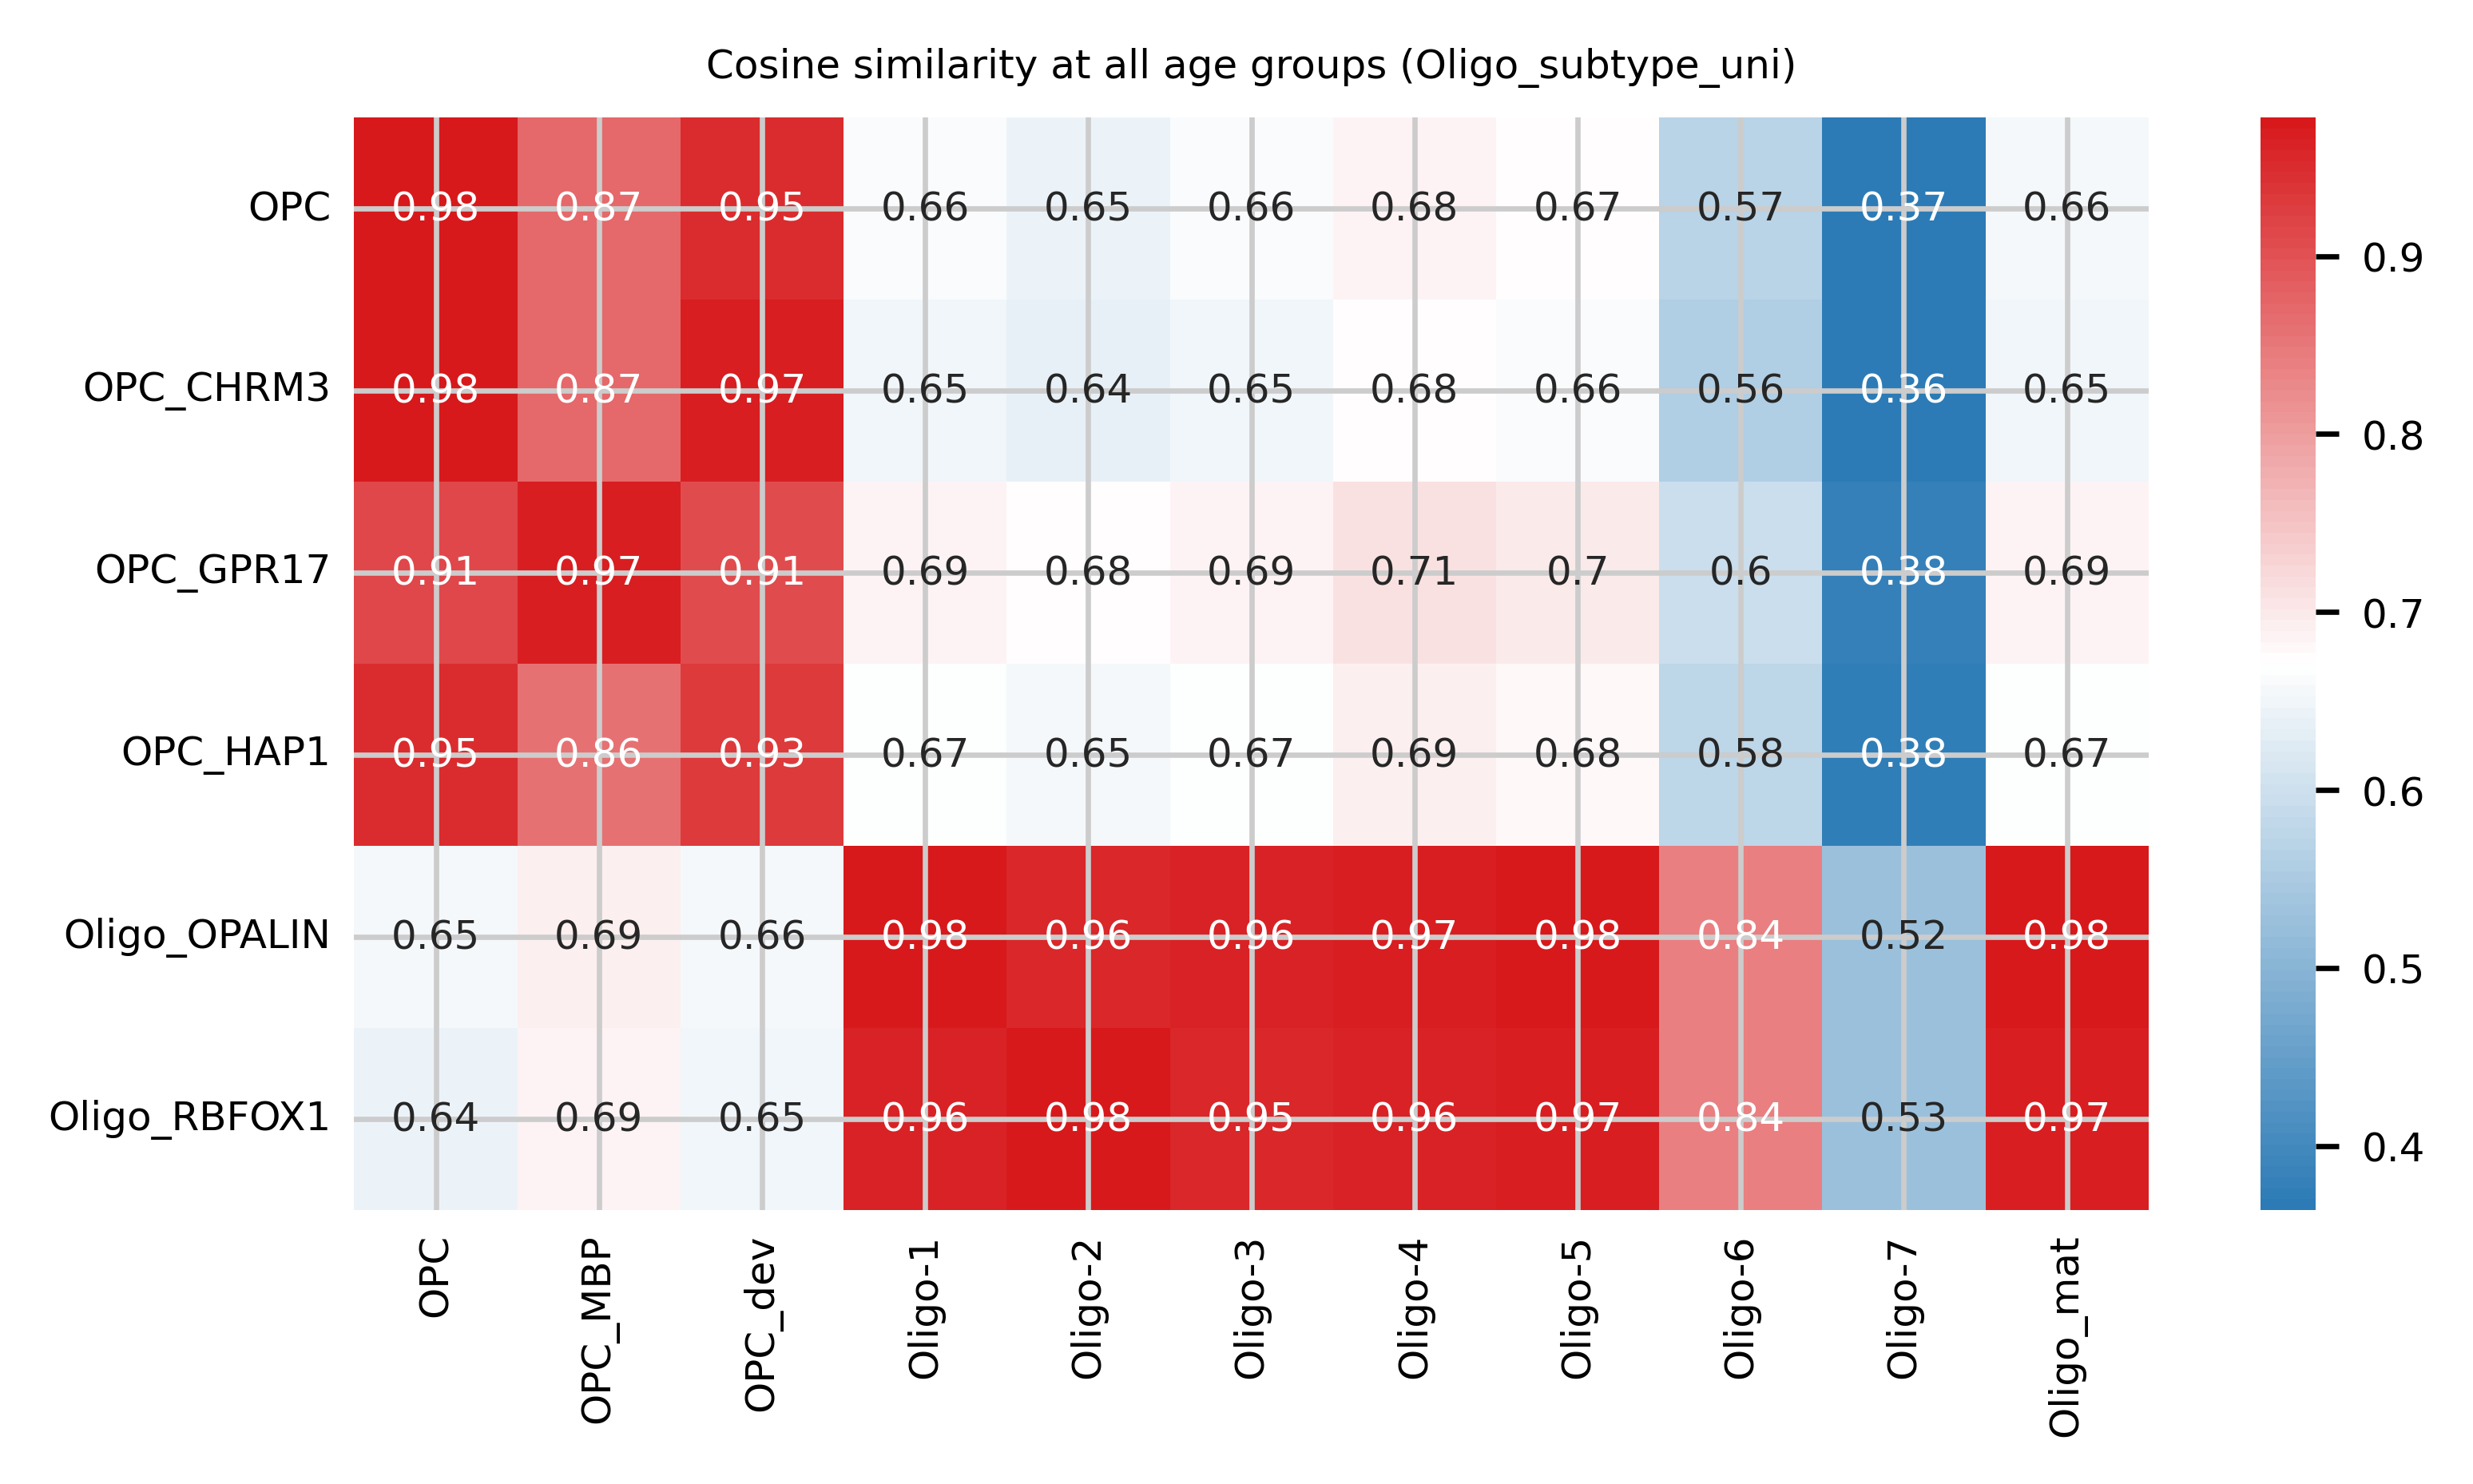

In [8]:
similarity_cell_type_all(ad_oligo, 'subtype_uni', 'Oligo_subtype_uni', 10, 'files/freeze3/figures/oligo_similarity_two_cohorts_subtype_uni_all.pdf')


In [16]:
ad_oligo.write('files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO.h5ad')


## Basic UMAP and UMAT analysis

In [ ]:
%%sh

python scripts/lineage_analysis_ryan_lister_fromLineageData.py \
-l files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO.h5ad \
-r 123456 \
-v scanpy@6000 \
-p half \
-n 25 \
-o files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456 \
-k no \
-s False

### 6000 hvgs

In [9]:
adata_6k = sc.read('files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_clustering.h5ad')
adata_6k # 349,350 × 14,649

AnnData object with n_obs × n_vars = 553620 × 14666
    obs: 'Batch', 'SubID', 'Age', 'Sex', 'PMI', 'cell_type_uni', 'subclass_uni', 'subtype_uni', 'dev_mat_uni', 'numerical_age', 'stage_id', 'Channel', 'Source', 'poolID', 'prep', 'rep', 'class', 'subclass', 'subtype', 'RL#', 'age', 'chem', 'concat_id', 'Race', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust'
    var: 'gene_id-Aging', 'gene_name-Aging', 'gene_type-Aging', 'gene_chrom-Aging', 'gene_start-Aging', 'gene_end-Aging', 'n_cells-Aging', 'percent_cells-Aging', 'robust-Aging', 'highly_variable_features-Aging', 'ribosomal-Aging', 'mitochondrial-Aging', 'protein_cod

#### subclass_uni

/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cma

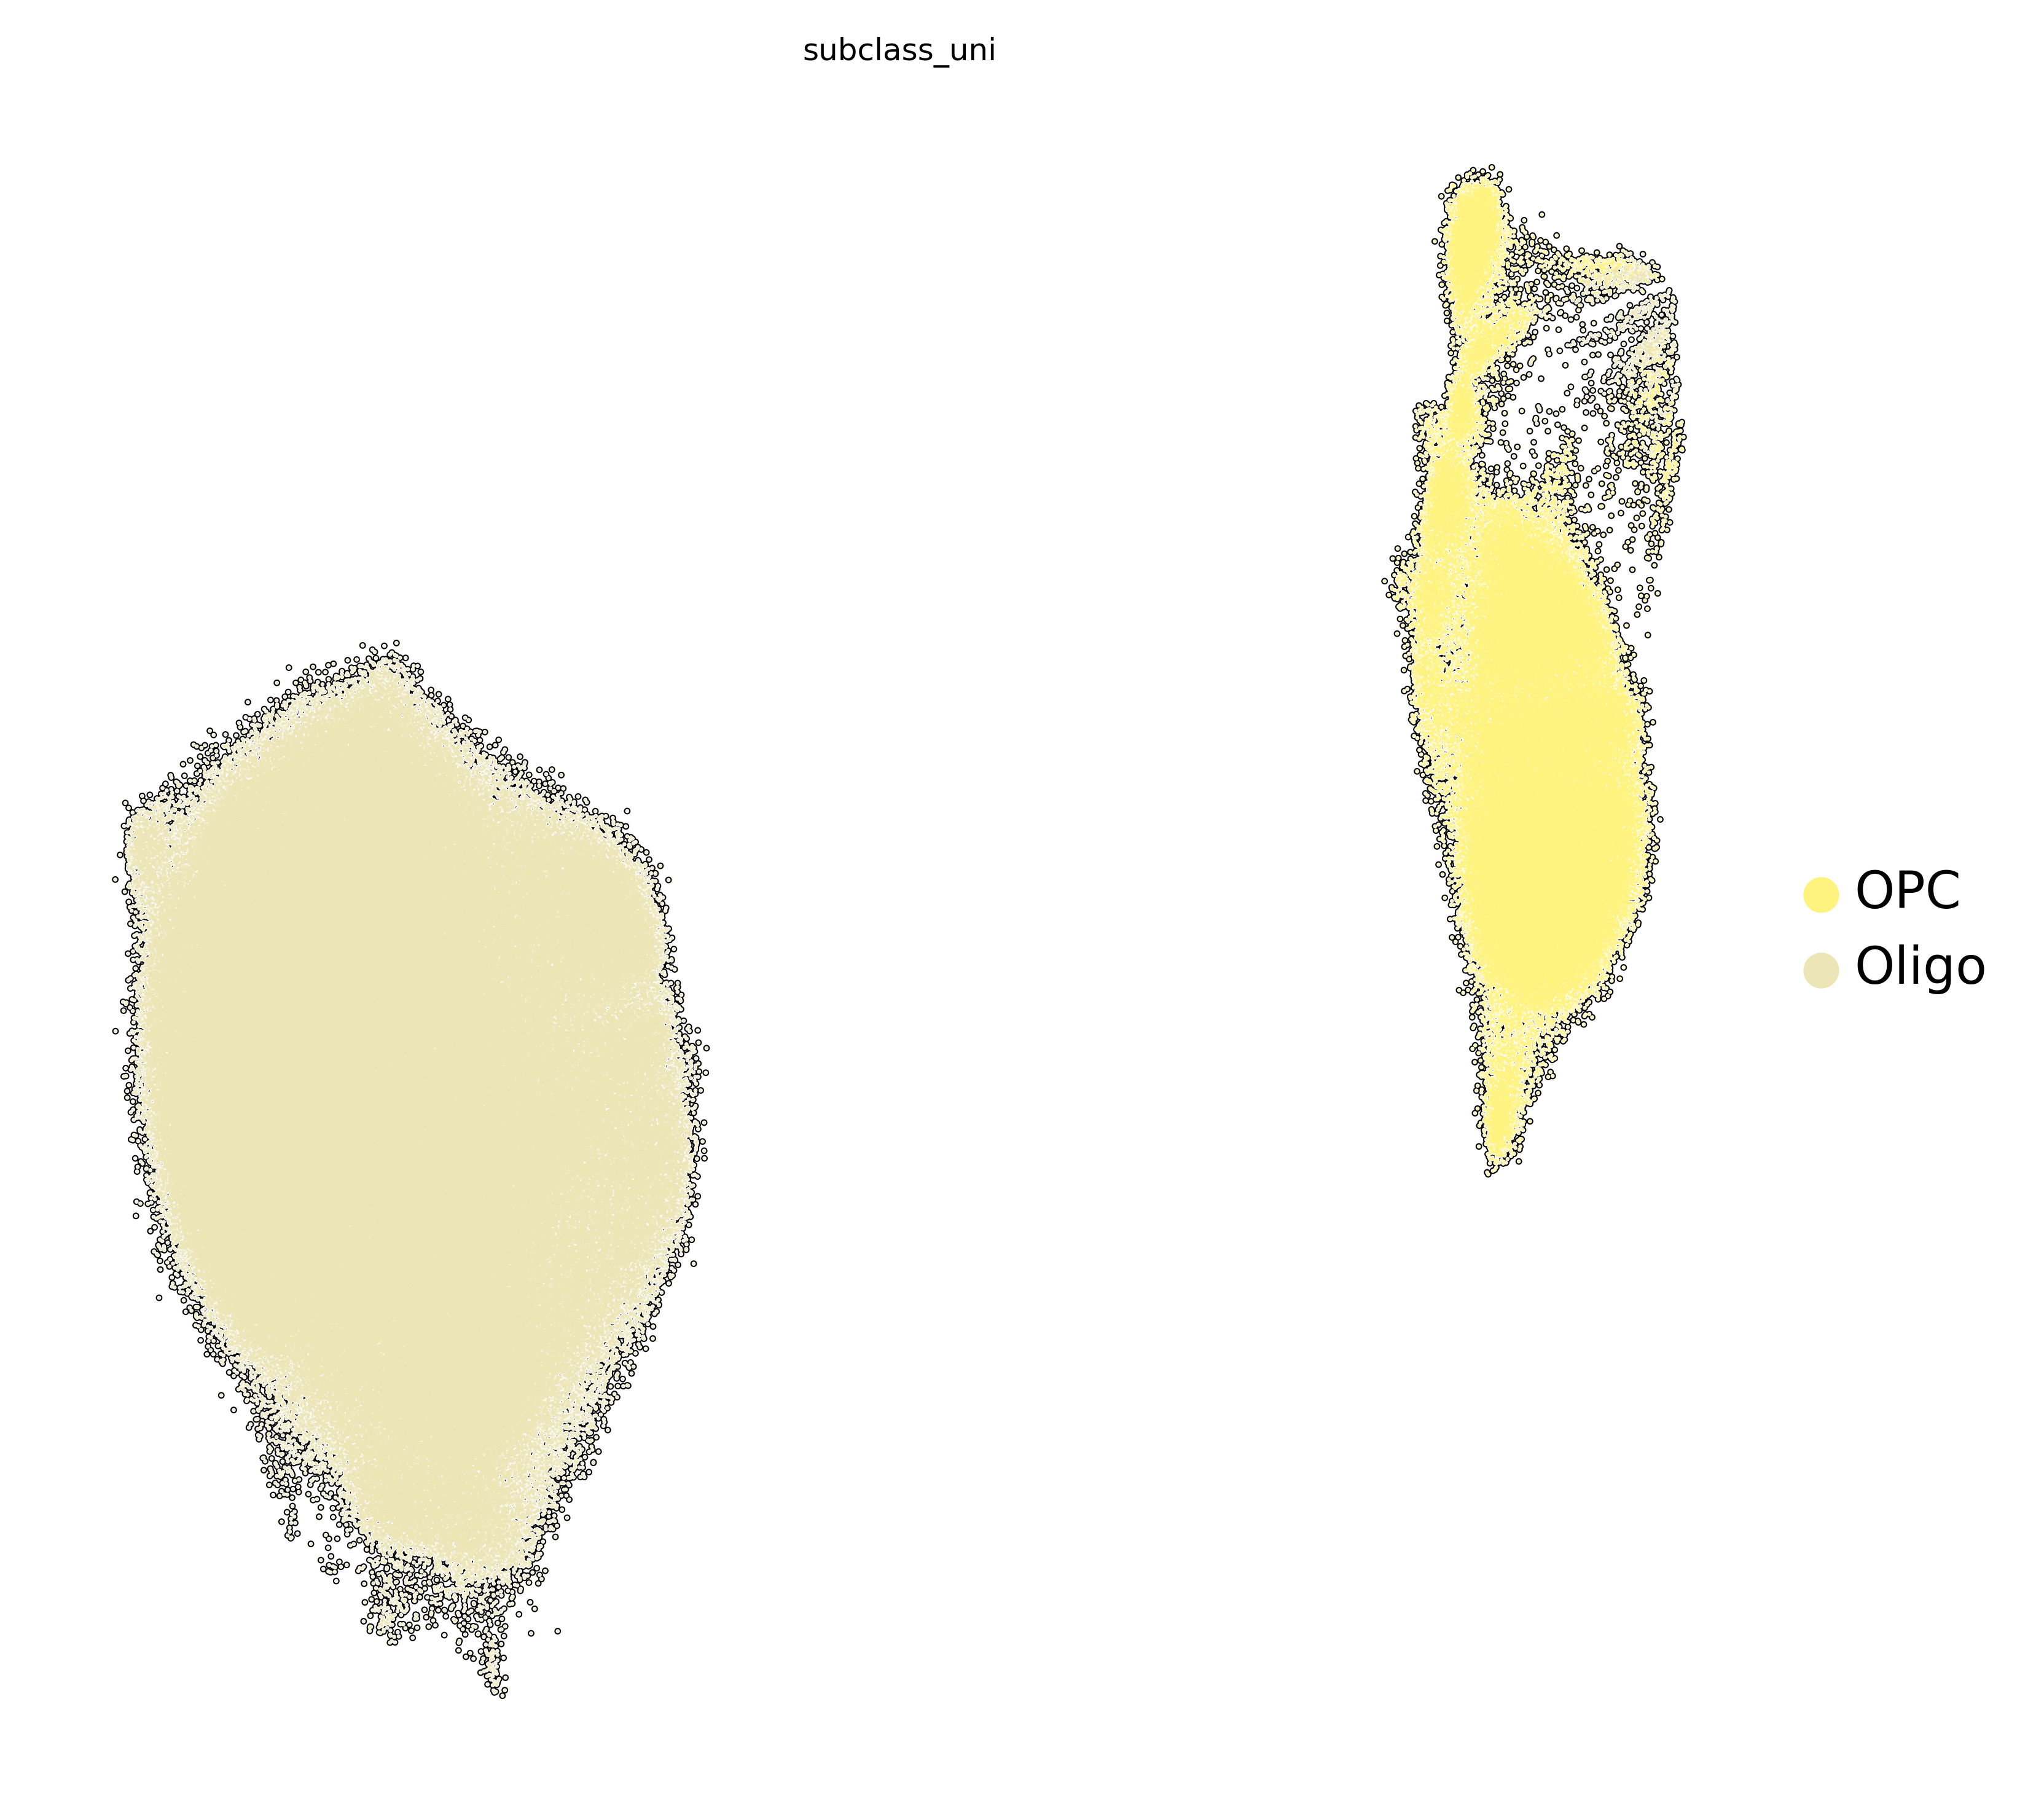

In [14]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.embedding(adata_6k, basis = 'umat', color='subclass_uni', add_outline=True,cmap='vlag',#legend_loc='on data',
               legend_fontsize=10, legend_fontoutline=2,frameon=False, palette=colors_subclass,
               outline_width=(0.5, 0.3), vmin=0, vmax=1,size=1,
               return_fig=True)
plt.savefig('files/freeze3/figures/oligo_data_umat_subclass_uni.pdf', transparent=True, format='pdf')

#### stage_id

In [ ]:
from pandas.api.types import CategoricalDtype
adata_6k.obs['stage_id_ord'] = adata_6k.obs['stage_id']
cat_dtype = CategoricalDtype(categories=adata_6k.uns['stage_order'], ordered=True)
adata_6k.obs['stage_id_ord'] = adata_6k.obs['stage_id_ord'].astype(cat_dtype)


/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cma

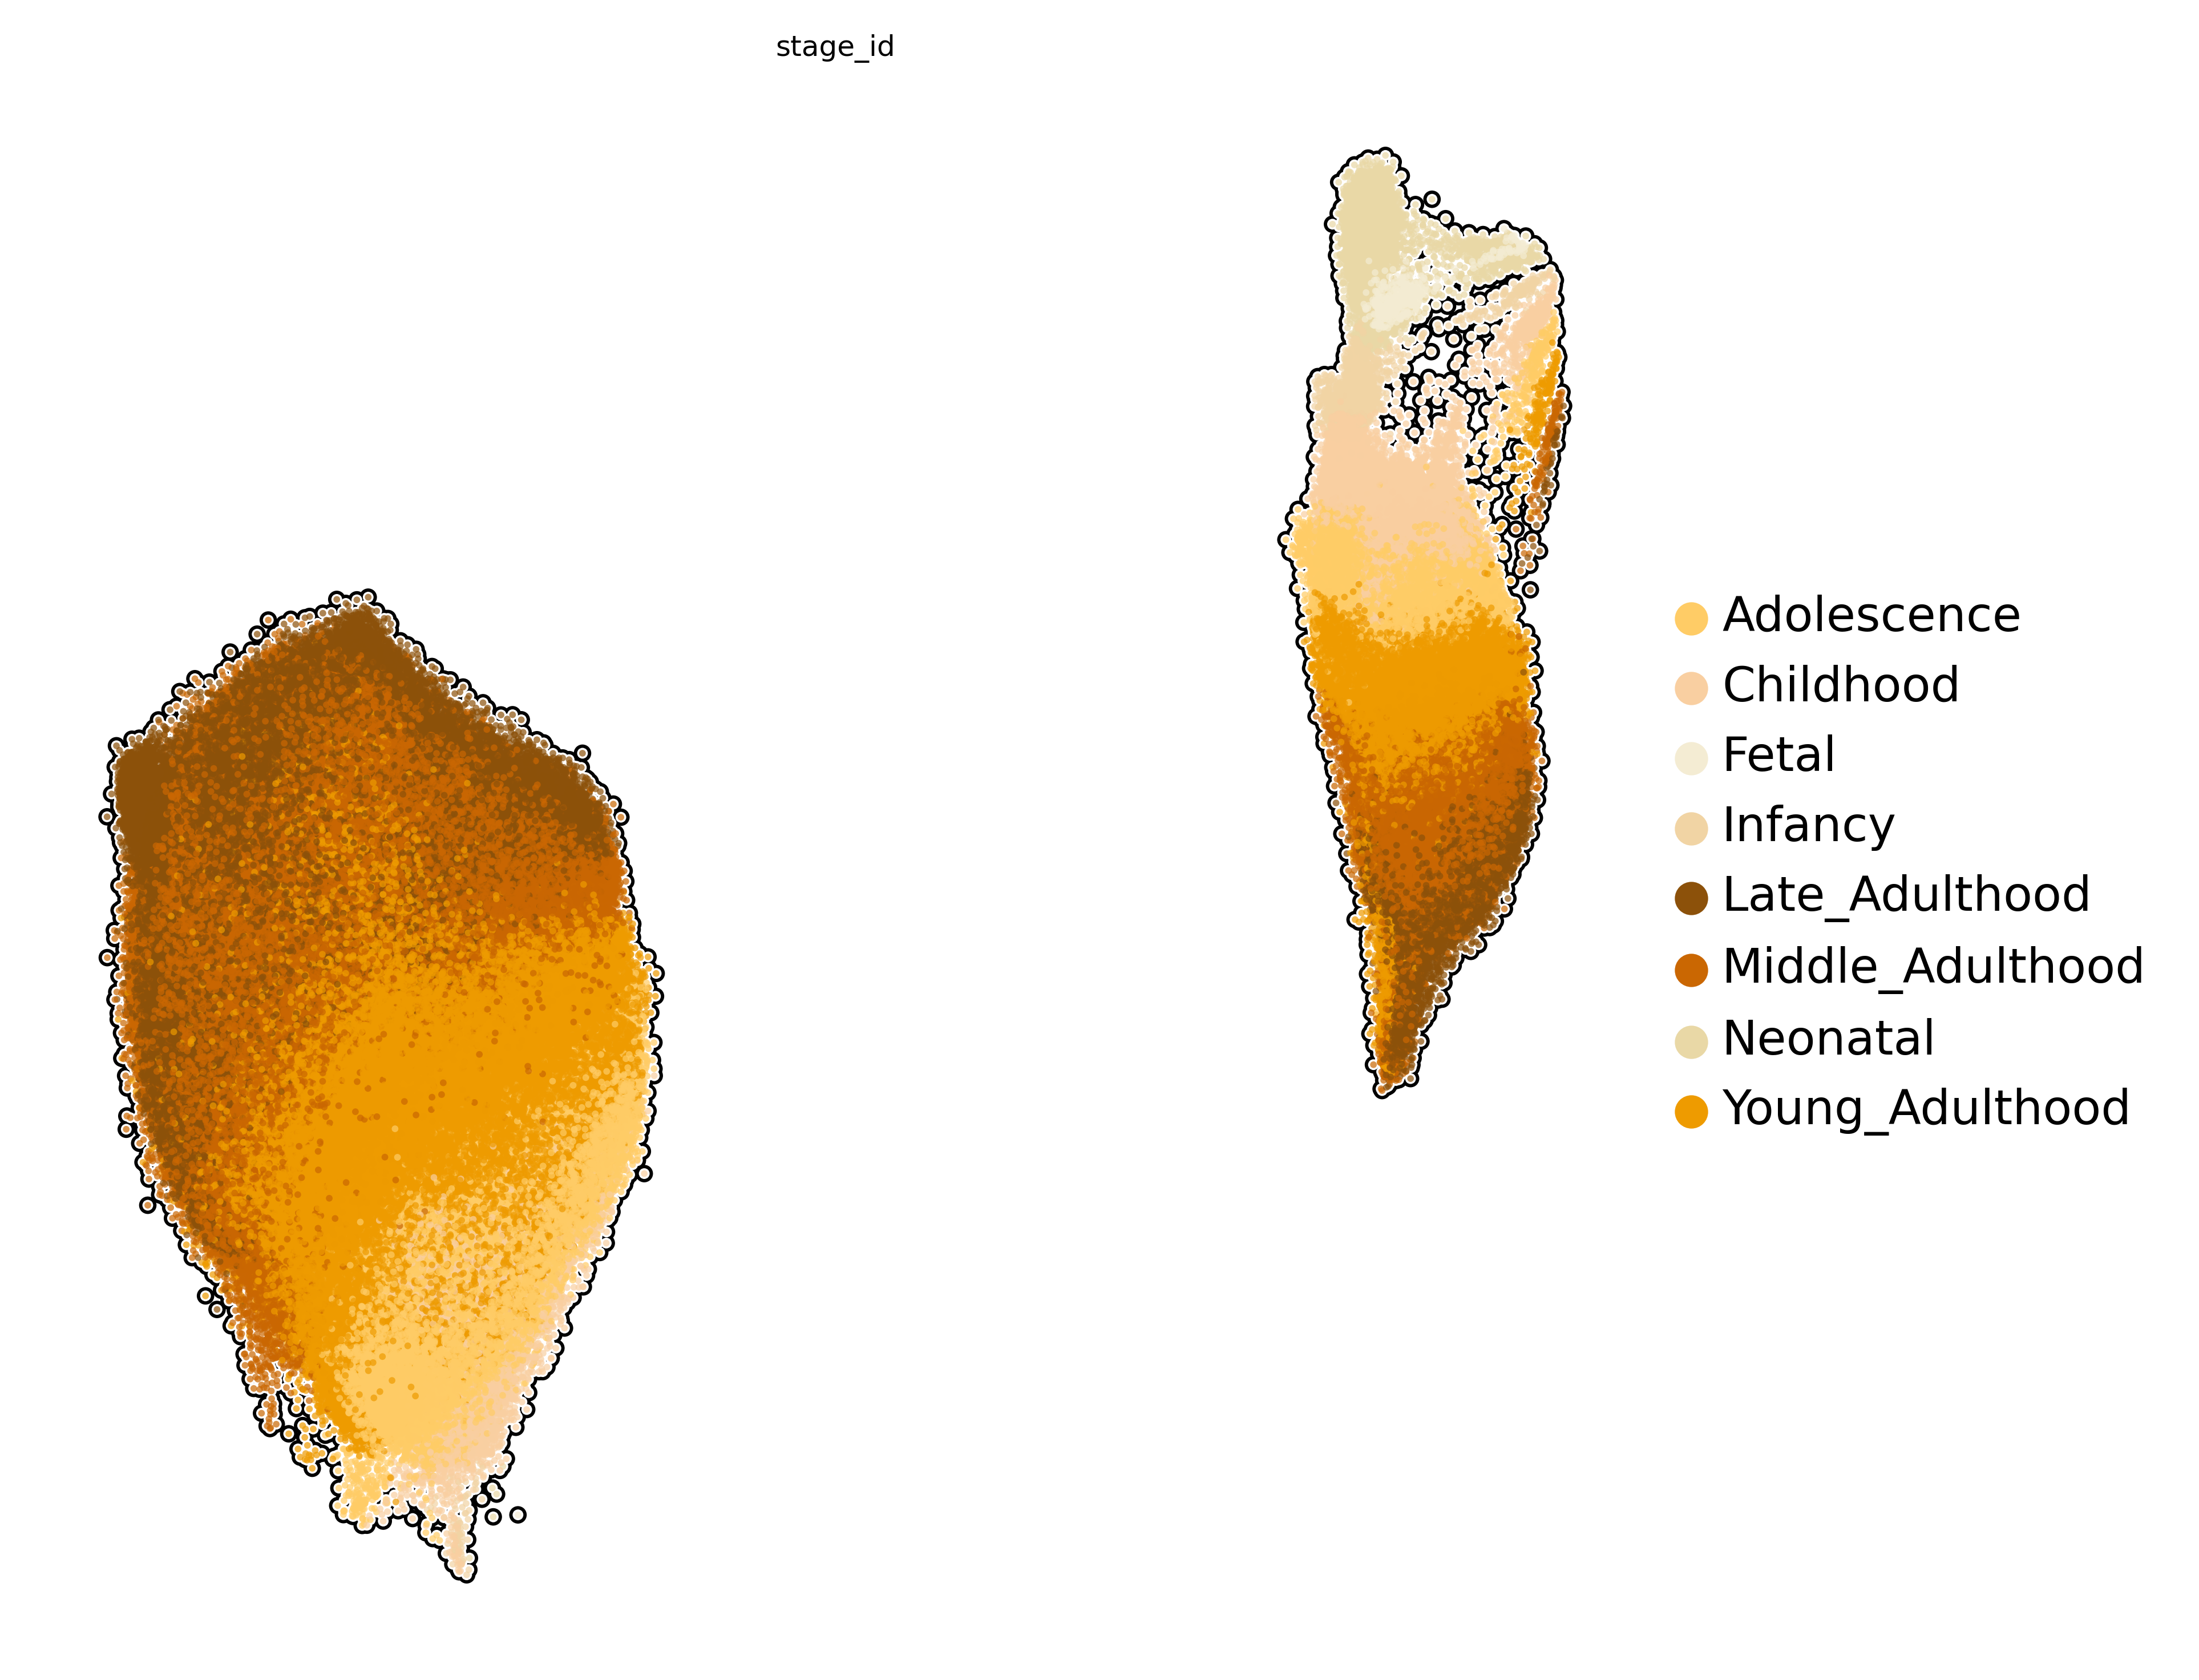

In [13]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.embedding(adata_6k, basis = 'umat', color='stage_id', add_outline=True,cmap='vlag',#legend_loc='on data',
               legend_fontsize=10, legend_fontoutline=2,frameon=False,palette=colors_stage_id,
               outline_width=(0.5, 0.3), vmin=0, vmax=1,size=8,
               return_fig=True)
plt.savefig('files/freeze3/figures/oligo_data_umat_stage_id.pdf', transparent=True, format='pdf')

# Pseudotime infer

In [ ]:
%%sh

Rscript scripts/freeze3/pseudotime_infer.R \
files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_clustering.h5ad \
files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456 \
12 \
8

## Data visualization

In [3]:
cds <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_beforeConstruction_cds.RDS")
d <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_beforeConstruction_d.RDS")
print(cds)
print(head(d))

class: cell_data_set_ext 
dim: 14666 553620 
metadata(0):
assays(2): counts logcounts
rownames(14666): DPM1 SCYL3 ... OOSP1 C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(553620): H1007-1-AAACGAAGTCTCAGGC-0-Aging
  H1007-1-AAACGAATCCCATAGA-0-Aging ...
  TTTGGAGAGTGGAATT-RL2132_25yr_v3-Lister
  TTTGTTGGTAAGGTCG-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):
       UMAP_1     UMAP_2
Y_1 11.987476  1.7705947
Y_2 11.714598  2.2714465
Y_3 -3.461342 -1.0875109
Y_4 -3.781875 -1.3740625
Y_5 -2.396316 -0.7558586
Y_6 12.244112  3.4384248


Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
ℹ Please use `select()` instead.
ℹ The deprecated feature was likely used in the monocle3 package.
  Please report the issue to the authors.”


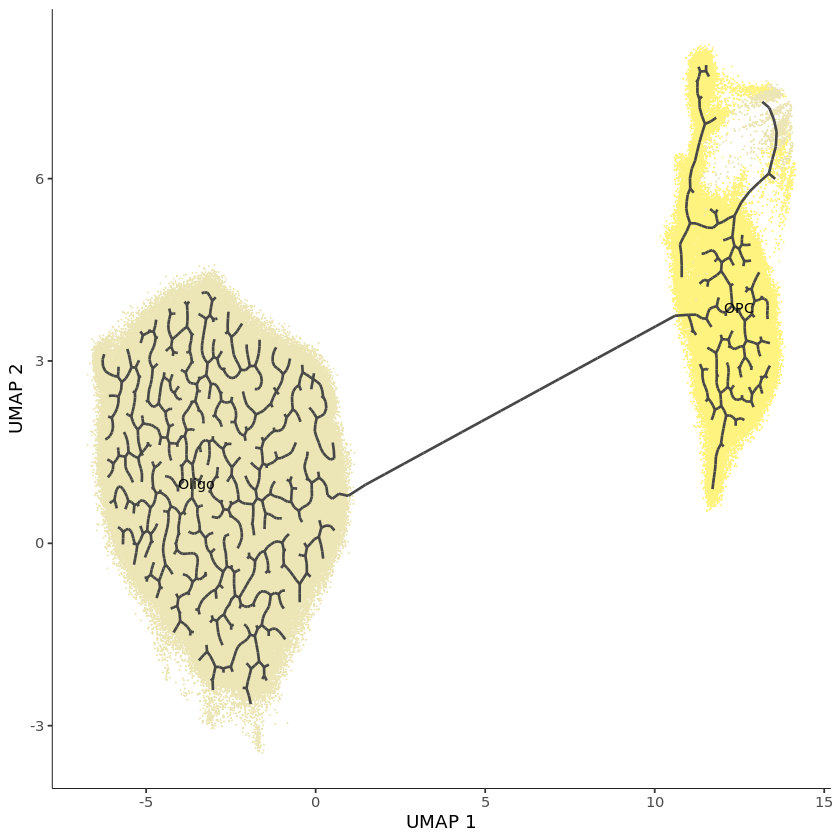

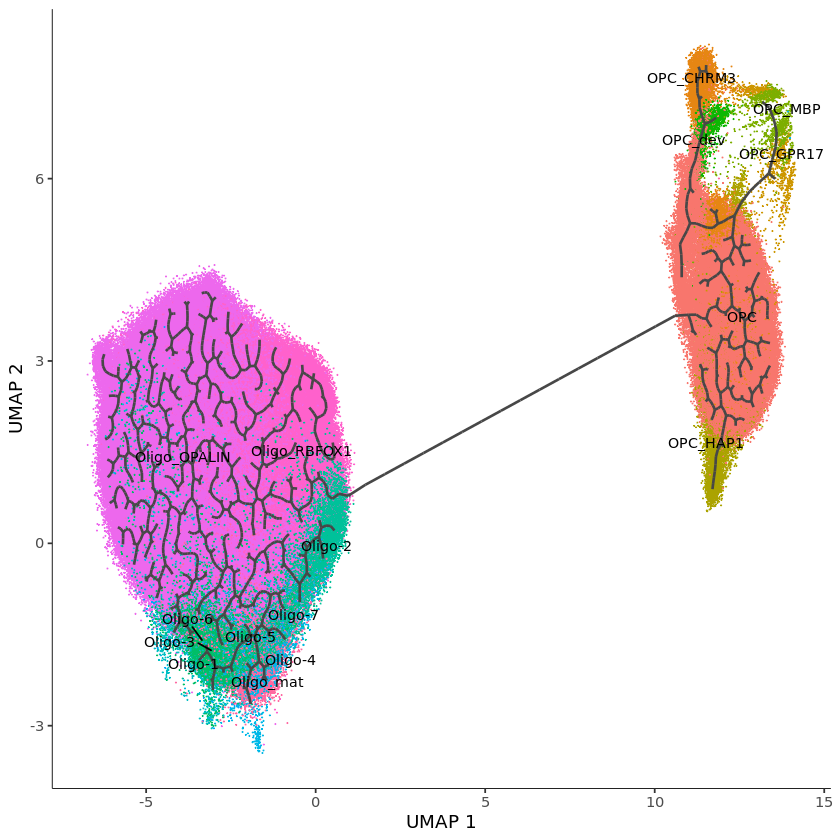

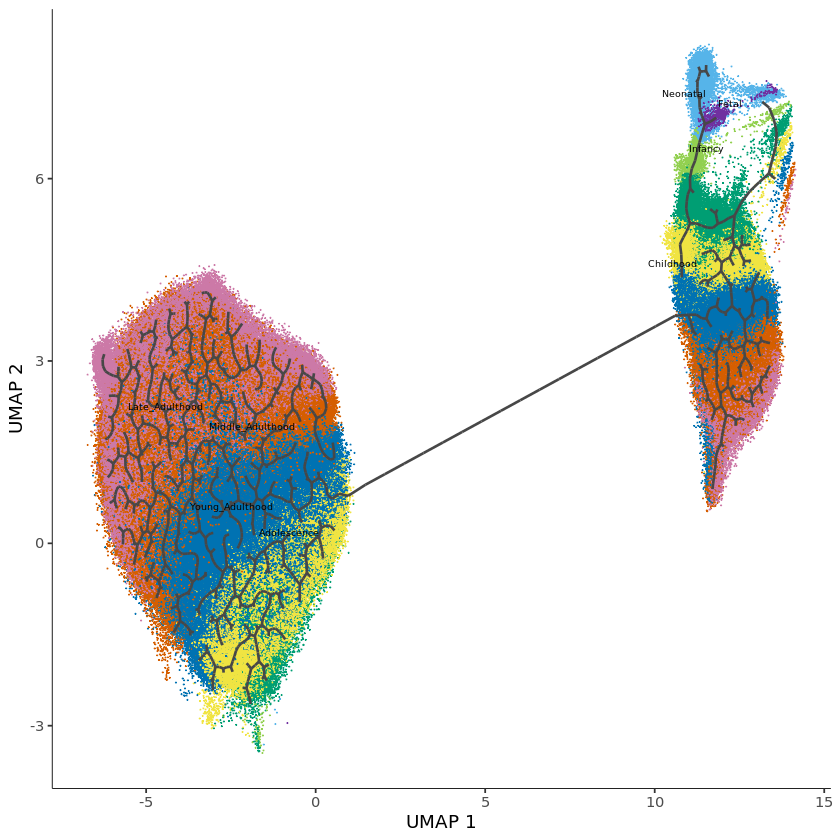

In [5]:
plot_cells(cds, color_cells_by = "subclass_uni", label_leaves = F, label_branch_points = F, label_principal_points = F, label_groups_by_cluster = F, group_label_size = 3) +
    scale_color_manual(values = cols_subclass_uni)

plot_cells(cds, color_cells_by = "subtype_uni", label_leaves = F, label_branch_points = F, label_principal_points = F, label_groups_by_cluster = F, group_label_size = 3)

plot_cells(cds, color_cells_by = "stage_id", label_leaves = F, label_branch_points = F, label_principal_points = F, label_groups_by_cluster = F) +
    scale_color_manual(values = cols_stage_id)

### Principle graphs visualization

#### unit: 500

In [ ]:
for(i in seq(0, 3, 1)){
    print(ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.005) + geom_text_repel(data=d[(500*i+1):min(500*(i+1), 1378), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[(500*i+1):min(500*(i+1), 1378), ]), size=2, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1))
}

#### unit: 200

In [ ]:
for(i in seq(0, 7, 1)){
    print(ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.005) + geom_text_repel(data=d[(200*i+1):min(200*(i+1), 1378), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[(200*i+1):min(200*(i+1), 1378), ]), size=2, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1))
}

#### unit: 100

In [ ]:
for(i in seq(0, 14, 1)){
    print(ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.005) + geom_text_repel(data=d[(100*i+1):min(100*(i+1), 1378), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[(100*i+1):min(100*(i+1), 1378), ]), size=2, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1))
}

#### unit: 50

In [ ]:
for(i in seq(0, 28, 1)){
    print(ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.005) + geom_text_repel(data=d[(50*i+1):min(50*(i+1), 1378), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[(50*i+1):min(50*(i+1), 1378), ]), size=2, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1))
}

### Start point

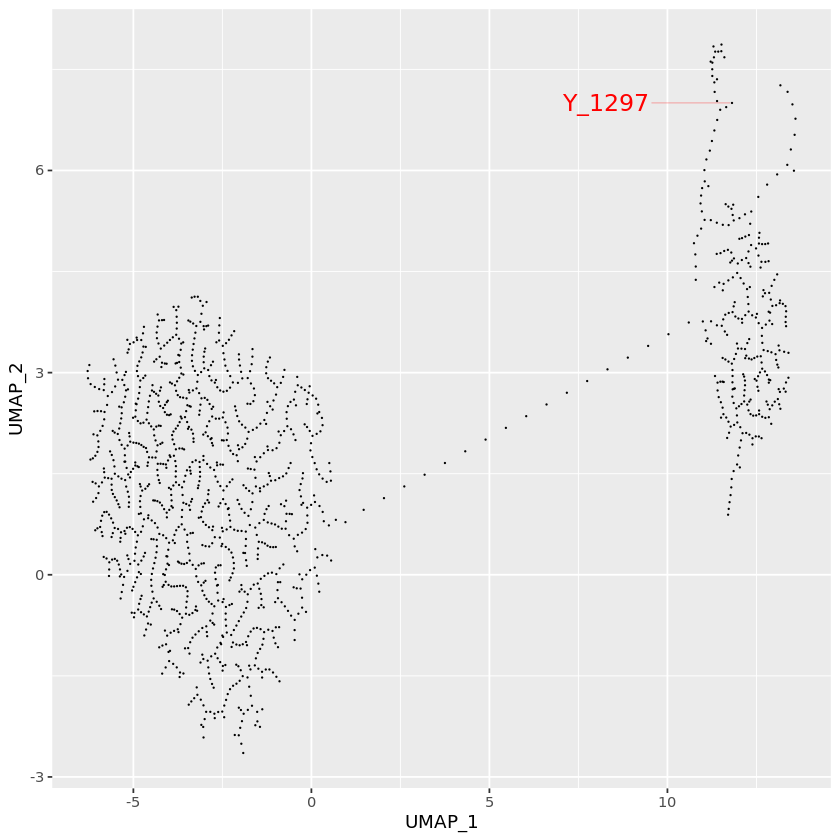

In [10]:
ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.01) + geom_text_repel(data=d[c(1297), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[c(1297), ]), size=5, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1)


### Node connection

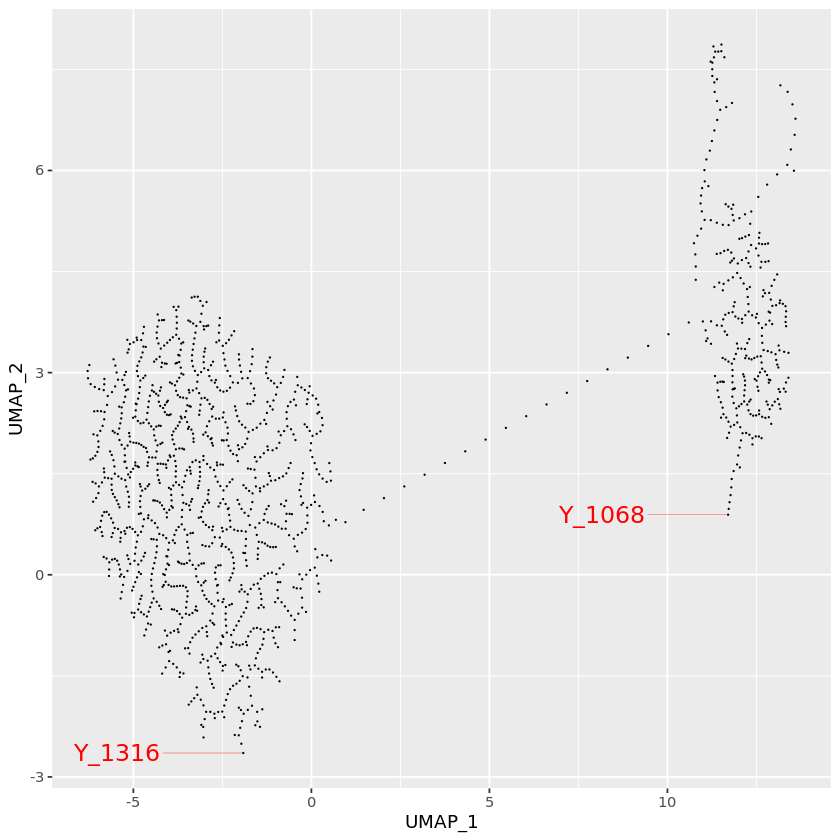

In [11]:
ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.01) + geom_text_repel(data=d[c(1068, 1316), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[c(1068, 1316), ]), size=5, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1)


### Terminal point

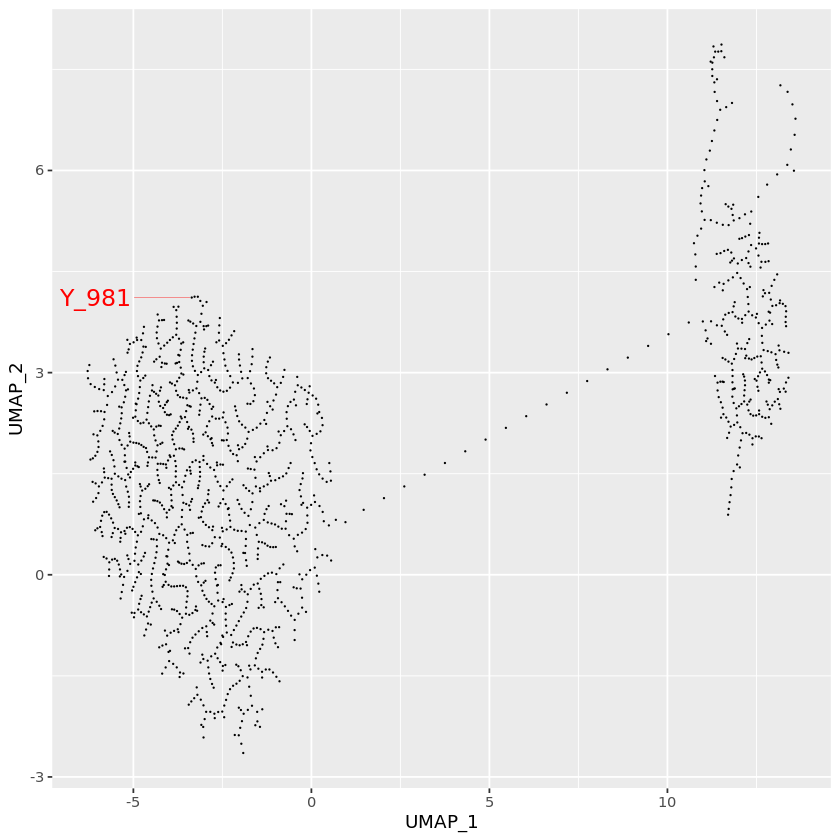

In [12]:
ggplot(data=d, aes(x=UMAP_1, y=UMAP_2)) + geom_point(size=0.01) + geom_text_repel(data=d[c(981), ], aes(x=UMAP_1, y=UMAP_2), label=rownames(d[c(981), ]), size=5, hjust = 2, color = "red", max.overlaps = Inf, segment.size = 0.1)


## Reconstruction

In [ ]:
# connect nodes
cds <- connect_nodes(cds, "Y_1068", "Y_1316")

# select individual lineages
lineage <- "Oligo"
print(lineage)
start <- 1297
end <- 981
inc.node <- c("Y_1068")
cds <- isolate_graph(cds, start, end, lineage, include_nodes = inc.node)
sel.cluster <- as.character(unique(colData(cds)[colData(cds)$subclass_uni %in% c("OPC", "Oligo"), ]$subtype_uni))
sel.cluster <- sel.cluster[!sel.cluster %in% c("OPC_MBP", "OPC_GPR17")]
cds <- isolate_lineage(cds, lineage, sel_clusters = sel.cluster, cl = 20, N = 10)

cds <- combine_lineages(cds, start)


In [9]:
saveRDS(cds, file = "/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_afterCombination_cds.RDS")


### Figure plots

#### pseudotime

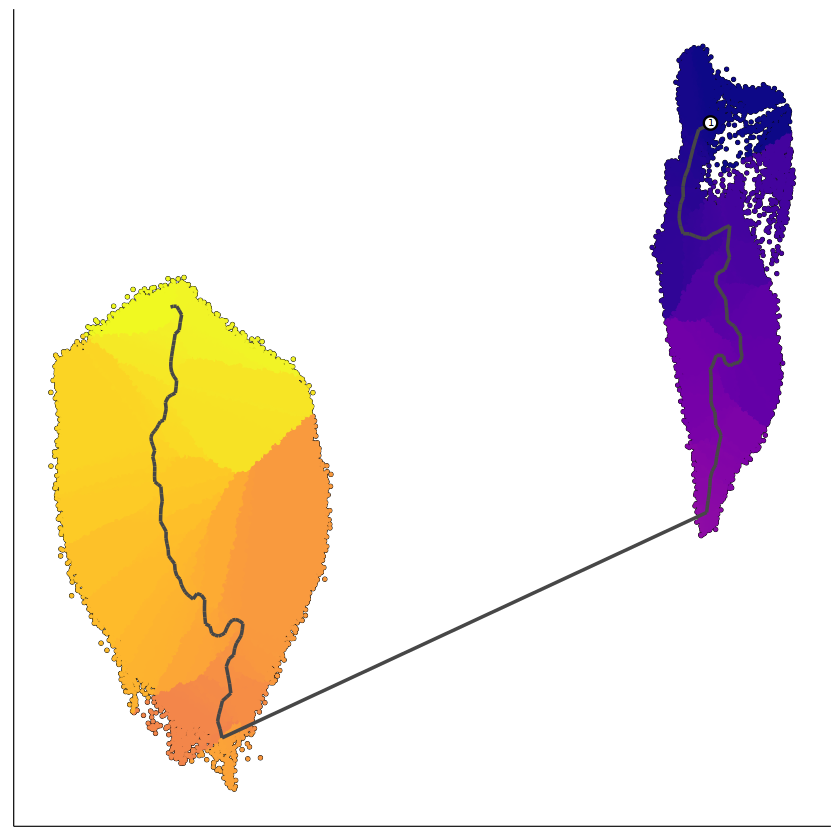

In [5]:
# midcolor
p_pseudotime <- plot_cells(cds, color_cells_by = "pseudotime", label_leaves = F, label_branch_points = F, label_principal_points = F, label_groups_by_cluster = F, label_cell_groups = F, cell_size = 0.5, cell_stroke = 0.3) + 
        theme(axis.text = element_blank(), 
          axis.ticks = element_blank(),
          axis.title = element_blank(), 
          panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(), 
          legend.position="none")
print(p_pseudotime)

In [6]:
ggsave("files/freeze3/figures/oligo_umat_pseudotime.png", plot = p_pseudotime, width = 6, height = 6, dpi = 150)

In [ ]:
p_pseudotime_w_legend <- plot_cells(cds, color_cells_by = "pseudotime", label_leaves = F, label_branch_points = F, label_principal_points = F, label_groups_by_cluster = F, label_cell_groups = F, cell_size = 0.5, cell_stroke = 0.3) + 
        theme(axis.text = element_blank(), 
          axis.ticks = element_blank(),
          axis.title = element_blank(), 
          panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())

In [8]:
ggsave("files/freeze3/figures/oligo_umat_pseudotime_legend.png", plot = p_pseudotime_w_legend, width = 6, height = 6, dpi = 150)

## Maturation rate of branches and lineages

### Regression of pseudotime along age

In [12]:
pdf("files/freeze3/figures/oligo_mature_ratio_regression.pdf", width = 4.5, height = 4.5)
regress_pt_along_age(cds, "Oligodendrocyte")
dev.off()

png 
  2

## Identify DEGs along trajectory

### Using modified moran test

In [ ]:
%%sh

for sub_lineage in Oligo
do
    Rscript scripts/freeze3/modified_moran_test_lineage.R \
        files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_afterCombination_cds.RDS \
        ${sub_lineage} \
        1297 \
        0.05 \
        10000 \
        40 \
        files/freeze3/DEGs_moran_test/modified_10000/OLIGO
done # for sub_lineage end

## Compress data along each lineage into 500 meta-cells

In [6]:
cds <- compress_lineages(cds, 1297, N = 500, cores = 40)
print(cds)
print(length(cds@expression))

[1] "Oligo"



Projecting cells to principal points for partition: 1



[1] "Window: 964.226"
[1] "Step: 962.297548"
[1] "Compressing lineage Oligo and fitting curves"


Loading required package: speedglm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: biglm

Loading required package: DBI



class: cell_data_set_ext 
dim: 14666 553620 
metadata(0):
assays(2): counts logcounts
rownames(14666): DPM1 SCYL3 ... OOSP1 C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(553620): H1007-1-AAACGAAGTCTCAGGC-0-Aging
  H1007-1-AAACGAATCCCATAGA-0-Aging ...
  TTTGGAGAGTGGAATT-RL2132_25yr_v3-Lister
  TTTGTTGGTAAGGTCG-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):
[1] 1


In [9]:
saveRDS(cds, file = "files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_afterCombination_cds_compressed.RDS")
